# Import packages

In [1]:
import os
import csv
from pathlib import Path
from copy import deepcopy
import time
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib
import pickle

import torch
from lightning import pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import Callback

import chemprop
from chemprop import data, featurizers, models, nn
from chemprop.featurizers.molecule import RDKit2DFeaturizer
from chemprop.utils import make_mol

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

import logging

# logging.getLogger('lightning').setLevel(0)

# configure logging at the root level of Lightning
# logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

# configure logging on module level, redirect to file
# logger = logging.getLogger("lightning.pytorch.core")
# logger.addHandler(logging.FileHandler("core.log"))

# logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.ERROR)
# logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)

# logging.getLogger("lightning.fabric.plugins.environments.slurm").setLevel(logging.ERROR)
# logging.getLogger("lightning.pytorch.callbacks.model_checkpoint").setLevel(logging.ERROR)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

# from xgboost import XGBRegressor

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from skopt.plots import plot_objective
# from skopt.plots import plot_convergence

## Load data

In [3]:
chemprop_dir = Path.cwd().parent
data_path = '../train_split_fluor.csv'

smiles_columns = ['Chromophore', 'Solvent']
target_columns = ['Absorption max (nm)', 'Emission max (nm)', 'log_q_yield']

In [4]:
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
batch_size = 512

In [5]:
data_df = pd.read_csv(data_path)

## Preprocess data

In [6]:
def drop_extra(df, columns):
    return df[columns]

def dropna(df):
    return df.dropna(subset=['Absorption max (nm)', 'Emission max (nm)', 'Stokes shift', 'Quantum yield'], how='all')

def replace_gas(df):
    df.loc[df['Solvent'] == 'gas', 'Solvent'] = df['Chromophore']
    return df

def remove_neg_shift(df):
    return df[(df['Stokes shift'] >= 0.0) | (df['Stokes shift'].isna())]

def make_log_q_yield(df, eps=1e-5):
    df_tmp = df.copy()
    df_tmp.loc[df_tmp['Quantum yield'] == 0.0, 'Quantum yield'] = eps
    df_tmp.loc[:, 'log_q_yield'] = np.log(df_tmp['Quantum yield'])
    return df_tmp

def delete_outliers(df, columns):
    for column in columns:
        print(column)
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        df = df[
            ((df[column] > q1 - 1.5 * iqr) & (df[column] < q3 + 1.5 * iqr))
            | (df[column].isna())
        ]

        print("left", q1 - 1.5 * iqr)
        print("right", q3 + 1.5 * iqr)
        print("=" * 100)
    return df

def preprocess_train(df):
    df = drop_extra(df, smiles_columns + ['Absorption max (nm)', 'Emission max (nm)', 'Stokes shift', 'Quantum yield'])
    df = dropna(df)
    df = replace_gas(df)
    df = remove_neg_shift(df)
    df = make_log_q_yield(df)
    df = drop_extra(df, smiles_columns + target_columns)
    return df

def preprocess_test(df):
    df = drop_extra(df, smiles_columns + ['Absorption max (nm)', 'Emission max (nm)', 'Stokes shift', 'Quantum yield'])
    df = dropna(df)
    df = replace_gas(df)
    df = remove_neg_shift(df)
    df = make_log_q_yield(df)
    df = drop_extra(df, smiles_columns + target_columns)
    return df

In [7]:
data_clean = preprocess_train(data_df)
data_clean.shape

(18110, 5)

In [8]:
test_data_df = pd.read_csv('../test_split_fluor.csv')
test_data_df.shape

(1850, 16)

In [9]:
test_data_clean = preprocess_test(test_data_df)
test_data_clean.shape

(1823, 5)

### Prepare data for training

In [10]:
smiss = data_clean.loc[:, smiles_columns].values
ys = data_clean.loc[:, target_columns].values

In [11]:
test_smiss = test_data_clean.loc[:, smiles_columns].values
test_ys = test_data_clean.loc[:, target_columns].values

In [12]:
smiss.shape

(18110, 2)

In [13]:
molecule_featurizer = RDKit2DFeaturizer()

def generate_mol_features(smiss, save_file, molecule_featurizer=molecule_featurizer):
    mols = [make_mol(smis, keep_h=False, add_h=False) for smis in smiss]
    extra_datapoint_descriptors = [molecule_featurizer(mol) for mol in tqdm(mols)]
    np.savez(save_file, extra_datapoint_descriptors)
    return extra_datapoint_descriptors

def load_mol_features(save_file):
    extra_mol_features = np.load(save_file)
    return [extra_mol_features[f"arr_{i}"] for i in range(len(extra_mol_features))][0]

/home/kashurin/soft/chemprop/chemprop/featurizers/molecule.py:52: UserWarning: The RDKit 2D features can deviate signifcantly from a normal distribution. Consider manually scaling them using an appropriate scaler before creating datapoints, rather than using the scikit-learn `StandardScaler` (the default in Chemprop).
  warnings.warn(


In [14]:
# save_file = 'rdkit_feats_1.npz'
# extra_datapoint_descriptors_1 = generate_mol_features(smiss[:, 0], save_file)

In [15]:
save_file = 'rdkit_feats_1.npz'
extra_datapoint_descriptors_1 = load_mol_features(save_file)

In [16]:
# save_file = 'rdkit_feats_2.npz'
# extra_datapoint_descriptors_2 = generate_mol_features(smiss[:, 1], save_file)

In [17]:
save_file = 'rdkit_feats_2.npz'
extra_datapoint_descriptors_2 = load_mol_features(save_file)

In [18]:
# save_file = 'rdkit_feats_1_test.npz'
# extra_datapoint_descriptors_1_test = generate_mol_features(test_smiss[:, 0], save_file)

In [19]:
save_file = 'rdkit_feats_1_test.npz'
extra_datapoint_descriptors_1_test = load_mol_features(save_file)

In [20]:
# save_file = 'rdkit_feats_2_test.npz'
# extra_datapoint_descriptors_2_test = generate_mol_features(test_smiss[:, 1], save_file)

In [21]:
save_file = 'rdkit_feats_2_test.npz'
extra_datapoint_descriptors_2_test = load_mol_features(save_file)

In [22]:
type(extra_datapoint_descriptors_2_test)

numpy.ndarray

In [23]:
extra_datapoint_descriptors = np.concatenate((
    extra_datapoint_descriptors_1,
    extra_datapoint_descriptors_2),
    axis=1
)
extra_datapoint_descriptors.shape

(18110, 420)

In [24]:
extra_datapoint_descriptors_test = np.concatenate((
    extra_datapoint_descriptors_1_test,
    extra_datapoint_descriptors_2_test),
    axis=1
)
extra_datapoint_descriptors_test.shape

(1823, 420)

In [25]:
all_data = [[data.MoleculeDatapoint.from_smi(smis[0], y, x_d=X_d) \
             for smis, y, X_d in zip(smiss, ys, extra_datapoint_descriptors)]]
all_data += [[data.MoleculeDatapoint.from_smi(smis[1]) \
              for smis in smiss]]

In [26]:
test_data = [[data.MoleculeDatapoint.from_smi(smis[0], y, x_d=X_d) \
              for smis, y, X_d in zip(test_smiss, test_ys, extra_datapoint_descriptors_test)]]
test_data += [[data.MoleculeDatapoint.from_smi(smis[1]) \
               for smis in test_smiss]]

In [27]:
component_to_split_by = 1
mols = [d.mol for d in all_data[component_to_split_by]]
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.9, 0.05, 0.05))
val_indices += test_indices
train_data, val_data, _ = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

In [28]:
len(train_data[0]) + len(val_data[0])

18110

In [29]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_datasets = [data.MoleculeDataset(train_data[i], featurizer) for i in range(len(smiles_columns))]
val_datasets = [data.MoleculeDataset(val_data[i], featurizer) for i in range(len(smiles_columns))]
test_datasets = [data.MoleculeDataset(test_data[i], featurizer) for i in range(len(smiles_columns))]

In [30]:
train_mcdset = data.MulticomponentDataset(train_datasets)

scaler = train_mcdset.normalize_targets()
extra_datapoint_descriptors_scaler = train_mcdset.normalize_inputs("X_d")

val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler)
val_mcdset.normalize_inputs("X_d", extra_datapoint_descriptors_scaler)

test_mcdset = data.MulticomponentDataset(test_datasets)
# tmp
# test_mcdset.normalize_inputs("X_d", extra_datapoint_descriptors_scaler)

In [31]:
train_loader = data.build_dataloader(train_mcdset, batch_size=batch_size)
val_loader = data.build_dataloader(val_mcdset, shuffle=False, batch_size=batch_size)
test_loader = data.build_dataloader(test_mcdset, shuffle=False, batch_size=batch_size)

## Training

In [32]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[
        nn.BondMessagePassing(
                d_h=512,
                dropout=0.1,
                depth=3,
                bias=True
            )
        for _ in range(len(smiles_columns))],
    n_components=len(smiles_columns),
)

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

ffn_input_dim = mcmp.output_dim + extra_datapoint_descriptors.shape[1]


ffn = nn.RegressionFFN(
    n_tasks=len(target_columns),
    output_transform=output_transform,
    input_dim=ffn_input_dim,
    hidden_dim=512,
    n_layers=4,
    dropout=0.5,
    activation="relu"
)

X_d_transform = nn.ScaleTransform.from_standard_scaler(extra_datapoint_descriptors_scaler[0])

mpnn = models.MulticomponentMPNN(
    mcmp,
    nn.MeanAggregation(),
    ffn,
    batch_norm=True,
    warmup_epochs=5,
    # init_lr=1e-5,
    max_lr= 2 * 1e-4,
    final_lr= 5 * 1e-5,
    metrics=[nn.metrics.RMSEMetric()],
    X_d_transform=X_d_transform
)

mpnn

MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=86, out_features=512, bias=True)
        (W_h): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=584, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=1444, out_features=512, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.5, inplace=

# Set up trainer

In [33]:
device = 0
model_dir = 'model_2'

In [48]:
checkpoint_cb = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath=model_dir,
    filename="{epoch:03d}-{val_loss:.3f}"
)

earlystopping_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15,
    min_delta=0.0
)

# class MetricTracker(Callback):
#     def __init__(self):
#         self.collection = []
    
#     def on_validation_batch_end(trainer, module, outputs, ...):
#         vacc = outputs['val_acc'] # you can access them here
#         self.collection.append(vacc) # track them
    
#     def on_validation_epoch_end(trainer, module):
#         elogs = trainer.logged_metrics # access it here
#         self.collection.append(elogs)
#         # do whatever is needed


trainer = pl.Trainer(
    logger=True,
    enable_progress_bar=True,
    accelerator="cuda",
    devices=[device],
    min_epochs=5,
    max_epochs=200,
    callbacks=[checkpoint_cb, earlystopping_cb],
)

/home/kashurin/soft/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kashurin/soft/miniconda3/envs/chemprop/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kashurin/soft/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to en

# Start training

In [49]:
trainer.fit(mpnn, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/kashurin/soft/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name            | Type                         | Params | Mode 
-------------------------------------------------------------------------
0 | message_passing | MulticomponentMessagePassing | 1.2 M  | train
1 | agg             | MeanAggregation              | 0      | train
2 | bn              | BatchNorm1d                  | 2.0 K  | train
3 | predictor       | RegressionFFN                | 1.5 M  | train
4 | X_d_transform   | ScaleTransform               | 0      | train
-------------------------------------------------------------------------
2.7 M     Trainable p

Sanity Checking: |                                                                                           |…

Training: |                                                                                                  |…


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [97]:
earlystopping_cb.best_score

tensor(0.3706, device='cuda:1')

In [271]:
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs

### Test results

In [273]:
ckpt_path = [None, 'model_'][0]
if ckpt_path is None:
    ckpt_path = 'best'
results = trainer.test(mpnn, test_loader, ckpt_path=ckpt_path)

Restoring states from the checkpoint path at /home/kashurin/gnn_1/model_2/epoch=199-val_loss=0.342.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/kashurin/gnn_1/model_2/epoch=199-val_loss=0.342.ckpt


Testing DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
batch_averaged_test/rmse    19.345558166503906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [274]:
results

[{'batch_averaged_test/rmse': 19.345558166503906}]

In [102]:
checkpoint_cb.best_model_path

'/home/kashurin/gnn_3/model_1/epoch=112-val_loss=0.371.ckpt'

In [35]:
# ckpt_path = checkpoint_cb.best_model_path
ckpt_path = 'model_1/epoch=089-val_loss=0.387.ckpt'

mpnn_predict = mpnn

with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        devices=[device]
    )
    testing_preds = trainer.predict(mpnn_predict, test_loader, ckpt_path=ckpt_path)

testing_preds = np.concatenate(testing_preds, axis=0)

/home/kashurin/soft/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kashurin/soft/miniconda3/envs/chemprop/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kashurin/soft/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to en

Predicting: |                                                                                                |…

In [118]:
ckpt_path = checkpoint_cb.best_model_path

mpnn_predict = models.MulticomponentMPNN(
    mcmp,
    nn.MeanAggregation(),
    ffn,
    batch_norm=True,
    warmup_epochs=5,
    # init_lr=1e-5,
    max_lr= 2 * 1e-4,
    final_lr= 5 * 1e-5,
    metrics=[nn.metrics.RMSEMetric()],
    # X_d_transform=X_d_transform
)

mpnn_predict = mpnn_predict.load_from_checkpoint(ckpt_path)

trainer = pl.Trainer(
    logger=None,
    enable_progress_bar=True,
    devices=[device]
)
testing_preds = trainer.predict(mpnn_predict, test_loader, ckpt_path=ckpt_path)

testing_preds = np.concatenate(testing_preds, axis=0)

/home/kashurin/soft/chemprop/chemprop/models/multi.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hparams = torch.load(checkpoint_path)["hyper_parameters"]
/home/kashu

Predicting: |                                                                                                |…

In [36]:
def rmsd(pred, target):
    mask = ~np.isnan(pred) & ~np.isnan(target)
    return root_mean_squared_error(pred[mask], target[mask])

In [37]:
print(f"RMSD Absorption max, nm: {rmsd(testing_preds[:, 0], test_ys[:, 0])}")
print(f"RMSD Emission max, nm: {rmsd(testing_preds[:, 1], test_ys[:, 1])}")
print(f"RMSD Log quantum yield, nm: {rmsd(testing_preds[:, 2], test_ys[:, 2])}")

RMSD Absorption max, nm: 1.1555909874362796e+33
RMSD Emission max, nm: 2.5358526076256896e+33
RMSD Log quantum yield, nm: 2.8968111544773912e+26


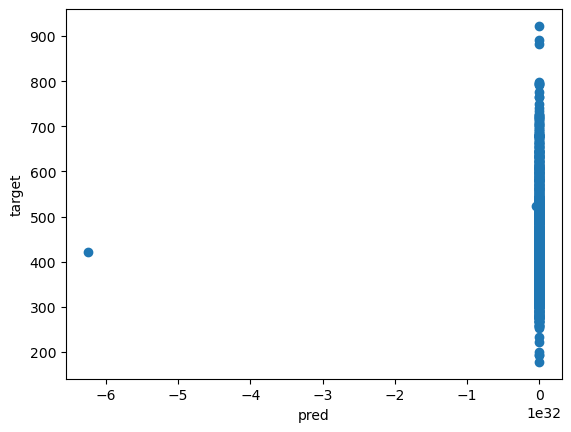

In [101]:
plt.scatter(testing_preds[:, 0], test_ys[:, 0])
plt.xlabel('pred')
plt.ylabel('target')
plt.show()

In [280]:
# from scipy.stats import pearsonr

def r2(pred, target):
    mask = ~np.isnan(pred) & ~np.isnan(target)
    return r2_score(pred[mask], target[mask])

In [281]:
print(f"R2 Absorption max: {r2(testing_preds[:, 0], test_ys[:, 0])}")
print(f"R2 Emission max: {r2(testing_preds[:, 1], test_ys[:, 1])}")
print(f"R2 Log quantum yield: {r2(testing_preds[:, 2], test_ys[:, 2])}")

R2 Absorption max: 0.9458543760636822
R2 Emission max: 0.9031947139046643
R2 Log quantum yield: 0.6496614997928065
